In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

#Train IELM and evaluating training accuracy
no_classes = 2
error = 0.1
loss_function = "binary_cross_entropy" #"mean_squared_error"  #It can be mean_absolute_error also
activation_function = "tanh"
import tensorflow as tf

# Set the GPU memory growth option
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)



In [ ]:
def loading_data(train_path,test_path):

    # Define the data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to (224, 224)
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
    ])

    

    train_dataset = ImageFolder(train_path, transform=transform)
    traindata_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

    test_dataset = ImageFolder(test_path, transform=transform)
    testdata_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
    return traindata_loader,testdata_loader

def load_model():
    #loading of model
    device=torch.device("cuda")  
    
    base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    base_model = torch.nn.Sequential(*list(base_model.children())[:-1])
    base_model=base_model.to(device)
    base_model.eval()
    return base_model
#training features extraction
def training_feature_extraction(device, traindata_loader,resnet_model):

    x_training_features = []
    y_train_labels = []
    with torch.no_grad():
        for images, labels in traindata_loader:        
            images = images.to(device)
            labels = labels.to(device)
            # Extract features using VGG16
            with torch.no_grad():
                features = resnet_model(images)   
            
            x_training_features.append(features)
            y_train_labels.append(labels)
    x_training_features = torch.cat(x_training_features, dim=0)
    y_train_labels = torch.cat(y_train_labels, dim=0)

    x_training_features.to(device)
    y_train_labels.to(device)
    return x_training_features,y_train_labels

def testing_feature_extratcion(device,testdata_loader,vgg_model):
    x_testing_features = []
    y_testing_labels = []
    with torch.no_grad():
        for images, labels in testdata_loader:
            images = images.to(device)
            labels = labels.to(device)
            # Extract features using VGG19
            with torch.no_grad():
                features = vgg_model(images) 
            x_testing_features.append(vgg_model(images))
            y_testing_labels.append(labels)
    x_testing_features = torch.cat(x_testing_features, dim=0)
    y_testing_labels = torch.cat(y_testing_labels, dim=0)

    x_testing_features.to(device)
    y_testing_labels.to(device)
    return x_testing_features,y_testing_labels

"""
IELM Constructor class
"""
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
class I_ELM():
    """ Constructor to initialize node"""
    def __init__(self, no_input_nodes, max_no_hidden_nodes, no_output_nodes,
        activation_function='sigmoid', loss_function='mean_squared_error'):
        device=torch.device("cuda") 
        
        self.no_input_nodes = no_input_nodes
        self.no_hidden_nodes = 1
        self.no_output_nodes = no_output_nodes

        self.beta = torch.FloatTensor(self.no_hidden_nodes, self.no_output_nodes).uniform_(-1., 1.)
        self.beta=self.beta.to(device)
        
        # initialize weights between Input Layer and hidden layer
        self.alpha=torch.FloatTensor(self.no_input_nodes, self.no_hidden_nodes).uniform_(-1.,1.)
        self.alpha=self.alpha.to(device)
        
        # Initialize Biases
        self.bias =torch.zeros(size=(self.no_hidden_nodes,))
        self.bias=self.bias.to(device)
        # set an activation function
        self.activation_function = activation_function
       
        # set a loss function
        self.loss_function = loss_function
    
    def mean_squared_error(self,Y_True, Y_Pred):
        return 0.5 * torch.mean((Y_True - Y_Pred)**2)

    def mean_absolute_error(self, Y_True, Y_Pred):
        return torch.mean(torch.abs(Y_True - Y_Pred))
    
    def sigmoid(self, x):
        return 1. /(1.+ torch.exp(-x))
    
    def predict(self, X):
        return torch.tensor(self(X), dtype=torch.float32)
    
    def __call__(self, X):
        h = torch.sigmoid(torch.matmul(X,self.alpha) + self.bias)
        return torch.matmul(h,self.beta)
    
    def binary_cross_entropy(self,Y_true, Y_pred):
        lss=[]
        Y_pred = torch.clamp(Y_pred, min=1e-7, max=1.0 - 1e-7)
        loss_calculated=- (Y_true * torch.log(Y_pred) + (1 - Y_true) * torch.log(1 - Y_pred))
        '''loss_calculated_max=torch.argmax(loss_calculated, axis=-1)
        loss_calculated_max=loss_calculated_max.cpu()
        
        for i in range(len(loss_calculated_max)):
            l1=loss_calculated_max[i]
            lss.append(l1)
        #print(lss)
        plt.plot(range(1, Lmax), lss)
        plt.xlabel('Hidden Layer Neurons')
        plt.ylabel('Training Loss')
        #plt.title('BCE Loss Over Epochs')
        plt.show()
        '''
        loss=torch.mean(loss_calculated)
        return loss


    def plot_confusion(self,Y_true, Y_pred):
         
        # Calculate the confusion matrix 
        confusion = confusion_matrix(Y_true, Y_pred)
        
        # Extract values from the confusion matrix
        TP = confusion[1, 1]
        FP = confusion[0, 1]
        TN = confusion[0, 0]
        FN = confusion[1, 0]
        TPR= TP/(TP+FN)
        FPR=FP/(FP+TN)
        X=[0,TPR,1]
        Y=[0,FPR,1]
        AUCSCORE =np.trapz(Y,X)

        # Calculate precision, recall, and F1-score
        precision, recall, f1_score, _ = precision_recall_fscore_support(Y_true,Y_pred, average='binary')

        print("precision=",precision,"recall=",recall,"f1-score=",f1_score,"auc-score=",AUCSCORE)

        Sensitivity = confusion[0][0]/(confusion[0][0]+confusion[1][1])
        Specificity =confusion[1][1]/(confusion[0][1]+confusion[1][1])
        fpr = 1-Specificity
        print("sensitivity=",Sensitivity,"specificity=",Specificity,"fpr=",fpr)
        # Print the confusion matrix
        print("Confusion Matrix:",confusion)
         
        import pandas as pd

        data = {'Column1':[precision,recall,f1_score,AUCSCORE,Sensitivity,Specificity,fpr]}
        df_matric = pd.DataFrame(data=data)
        df_matric.index  = ['Precision', 'recall', 'f1-score','Accuracy Score','sensitivity','specificity','fpr']
        print(df_matric)

        
        # Get the number of classes
        num_classes = len(np.unique(Y_true))

        # Create a figure and axis
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(4,4))
        cmlabels=['Vacant','Occuped']
        # Plot the confusion matrix using a heatmap
        sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax,xticklabels=cmlabels,yticklabels=cmlabels)

        # Set axis labels and title
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("Actual labels")
        title="CM For testing on UFPR04"
        ax.set_title("")
        plt.savefig(title+'confusion_matrix.png')
        # Show the plot
        plt.show()



    def evaluate(self, X, Y_true, metrics):
        Y_pred =self.predict(X)
        #Y_true = Y_true
        
        ret = []
        
        Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


        for m in metrics:
            if m == 'loss':
                loss=[]
                loss = self.binary_cross_entropy(Y_true, Y_pred)
                ret.append(loss)                
            elif m == 'accuracy':
                Y_pred_argmax = torch.argmax(Y_pred, axis=-1)
                Y_true_argmax = torch.argmax(Y_true, axis=-1)
                acc = torch.sum(Y_pred_argmax == Y_true_argmax) / len(Y_true)
                #plotting of confusion matrix

                # Get predicted probabilities for positive class
                Y_true_argmax=Y_true_argmax.cpu()
                Y_pred_argmax=Y_pred_argmax.cpu()
                self.plot_confusion(Y_true_argmax, Y_pred_argmax)
                ret.append(acc)
            else:
                raise ValueError('an unknown evaluation indicator \'%s\'.' % m)
        if len(ret) == 1:
            print(ret)
            ret = ret
        elif len(ret) == 0:
            ret = None
        return ret

    def fit(self, X, Y_true,Lmax,error,activation):
        device=torch.device("cuda")
        with torch.no_grad():
            self.beta=torch.FloatTensor(np.random.uniform(-1.,1.,size=(1, self.no_output_nodes)))
            self.alpha = torch.FloatTensor(self.no_input_nodes, 1).uniform_(-1,1)
            print(self.beta.shape, self.alpha.shape,X.shape)
            
            self.alpha=self.alpha.to(device)
            self.beta=self.beta.to(device)
            if(activation=='s'):
                H = torch.sigmoid(torch.matmul(X, self.alpha))
            elif(activation=='t'):
                H = torch.tanh(torch.matmul(X, self.alpha))  
            elif(activation=='r'):
                H = torch.relu(torch.matmul(X, self.alpha))
            
            # Compute a pseudoinverse of H
            H_pinv = torch.pinverse(H)

            # Update beta
            self.beta = torch.matmul(H_pinv, Y_true.float())
            
            for i in range(2, Lmax):
                beta_random = torch.FloatTensor(np.random.uniform(-1.,1.,size=(1, self.no_output_nodes)))
                alpha_random = torch.FloatTensor(self.no_input_nodes, 1).uniform_(-1,1)
                
                beta_random=beta_random.to(device)
                alpha_random=alpha_random.to(device)
                
                self.alpha=torch.cat((self.alpha,alpha_random),dim=1)                          
                self.beta =torch.cat((self.beta,beta_random),dim=0)

                if(activation=='s'):
                    H = torch.sigmoid(torch.matmul(X, self.alpha))
                elif(activation=='t'):
                    H = torch.tanh(torch.matmul(X, self.alpha))  
                elif(activation=='r'):
                    H = torch.relu(torch.matmul(X, self.alpha))
                
                H_pinv = torch.pinverse(H)
                self.beta = torch.matmul(H_pinv, Y_true) 

from  keras.utils import np_utils
def train_features_conversion(x_training_features,y_train_labels):

    # Convert the extracted features to numpy arrays

    device=torch.device("cuda")
    x_training_features_np = x_training_features.detach().cpu().numpy()  
    flattened_features_train = x_training_features_np.reshape(x_training_features_np.shape[0], -1)
    train_features_tensor = torch.tensor(flattened_features_train, dtype=torch.float32).to(device)
    
    y_train_array= y_train_labels.cpu().detach().numpy()
    y_train_array_encoded = np_utils.to_categorical(y_train_array,no_classes)
    y_train_labels_encoded=torch.tensor(y_train_array_encoded,dtype=torch.float32)
    y_train_labels_encoded=y_train_labels_encoded.to(device)    
    return train_features_tensor,y_train_labels_encoded

def test_features_conversion(x_testing_features,y_testing_labels):
    # Convert the extracted features to numpy arrays
    device=torch.device("cuda")
    x_testing_features_np = x_testing_features.detach().cpu().numpy()
    
    flattened_features_test = x_testing_features_np.reshape(x_testing_features_np.shape[0], -1)
    test_features_tensor = torch.tensor(flattened_features_test,dtype=torch.float32).to(device)
    
    y_test_array= y_testing_labels.cpu().detach().numpy()
    y_test_array_encoded = np_utils.to_categorical(y_test_array,no_classes)
    y_test_labels_encoded=torch.tensor(y_test_array_encoded,dtype=torch.float32)
    y_test_labels_encoded=y_test_labels_encoded.to(device)
    return test_features_tensor, y_test_labels_encoded



In [ ]:
device=torch.device("cuda") 
train_path="D:/PretrainedIELM/Dataset/PUC/Cloudy/train/"
test_path="D:/PretrainedIELM/Dataset/PUC/Cloudy/test/"
traindata_loader,testdata_loader=loading_data(train_path,test_path)
model=load_model()


In [ ]:
x_training_features,y_train_labels=training_feature_extraction(device,traindata_loader,model)
train_features_tensor,y_train_labels_encoded=train_features_conversion(x_training_features,y_train_labels)
torch.save(train_features_tensor,"D:/PretrainedIELM/ResNet50/PUC_train_features.pth")
torch.save(y_train_labels_encoded,"D:/PretrainedIELM/ResNet50/PUC_train_labels.pth")

In [ ]:
x_testing_features,y_testing_labels=testing_feature_extratcion(device,testdata_loader,model)
test_features_tensor, y_test_labels_encoded=test_features_conversion(x_testing_features,y_testing_labels)


In [ ]:
torch.save(test_features_tensor,"D:/PretrainedIELM/ResNet50/PUC_test_features.pth")
torch.save(y_test_labels_encoded,"D:/PretrainedIELM/ResNet50/PUC_test_labels.pth")

In [ ]:
def i_elmTraining(features_train,y_train,activation):
  # ===============================
  # Instantiate ELM object
  # ===============================
  input=features_train.size(1)
  ielm_model = I_ELM(
      no_input_nodes=input,
      max_no_hidden_nodes=Lmax,
      no_output_nodes=no_classes,
      loss_function=loss_function,
      activation_function=activation_function,    
  )

  i = time.time()  
  ielm_model.fit(features_train,y_train,Lmax,error,activation)
  final = time.time()

  training_loss, training_acc = ielm_model.evaluate(features_train, y_train, metrics=['loss','accuracy'])
  
  print('Training Loss in mean square error: %f' % training_loss) # loss value
  print('Training Accuracy: %f' % training_acc)# accuracy
  print('Total Time require for Training %f Seconds'% (final-i))

  return ielm_model
def i_elmTesting(ielm_model,features_test,y_test):
  
  i = time.time()
  test_loss, test_acc = ielm_model.evaluate(features_test, y_test, metrics=['loss', 'accuracy'])
  final = time.time()
  
  print('Testing Loss in mean square error: %f ' % test_loss,"\n")
  print('Testing Accuracy: %f' % test_acc)
  time_taken=(final-i)/features_test.shape[0]
  print('Total Time require for Testing one image is ' ,time_taken ,'seconds')
  


In [ ]:
x_training_features=torch.load("D:/PretrainedIELM/ResNet50/UFPR05_train_features.pth")
y_train_labels=torch.load("D:/PretrainedIELM/ResNet50/UFPR05_train_labels.pth")


In [ ]:

x_testing_features=torch.load("D:/PretrainedIELM/ResNet50/UFPR05_test_features.pth")
y_testing_labels=torch.load("D:/PretrainedIELM/ResNet50/UFPR05_test_labels.pth")



torch.Size([1, 2]) torch.Size([2048, 1]) torch.Size([116049, 2048])
precision= 0.9866625401597547 recall= 0.9816856799319628 f1-score= 0.9841678181871637 auc-score= 0.018613597726020878
sensitivity= 0.41218666315466 specificity= 0.9866625401597547 fpr= 0.013337459840245258
Confusion Matrix: [[46946   905]
 [ 1249 66949]]
                 Column1
Precision       0.986663
recall          0.981686
f1-score        0.984168
Accuracy Score  0.018614
sensitivity     0.412187
specificity     0.986663
fpr             0.013337


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


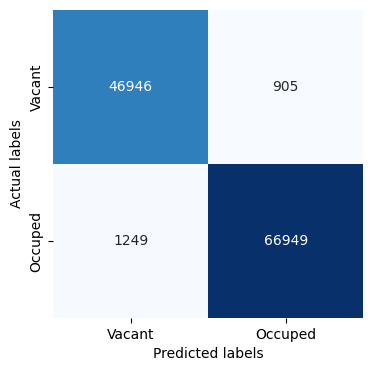

Training Loss in mean square error: 1.058890
Training Accuracy: 0.981439
Total Time require for Training 1.090328 Seconds


In [529]:
Lmax= 100
activation='r'
i_elm_model=i_elmTraining(x_training_features,y_train_labels,activation)


precision= 0.9892047993949187 recall= 0.9844327357328589 f1-score= 0.9868129983709165 auc-score= 0.015439181187598225
sensitivity= 0.4124001878816346 specificity= 0.9892047993949187 fpr= 0.010795200605081323
Confusion Matrix: [[20194   314]
 [  455 28773]]
                 Column1
Precision       0.989205
recall          0.984433
f1-score        0.986813
Accuracy Score  0.015439
sensitivity     0.412400
specificity     0.989205
fpr             0.010795


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


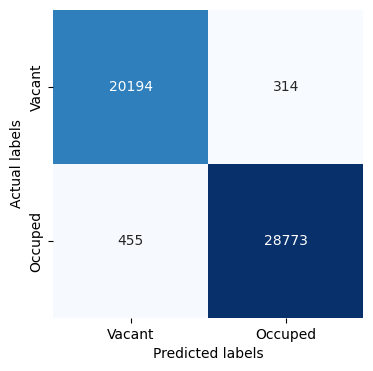

Testing Loss in mean square error: 1.056733  

Testing Accuracy: 0.984538
Total Time require for Testing one image is  2.8451127179167136e-06 seconds


In [530]:
i_elmTesting(i_elm_model,x_testing_features,y_testing_labels)

torch.Size([1, 2]) torch.Size([2048, 1]) torch.Size([116049, 2048])


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


precision= 0.9825497130268421 recall= 0.9940467462388927 f1-score= 0.9882647929209731 auc-score= 0.015557346196764405
sensitivity= 0.40761453700224576 specificity= 0.9825497130268421 fpr= 0.01745028697315787
Confusion Matrix: [[46647  1204]
 [  406 67792]]
                 Column1
Precision       0.982550
recall          0.994047
f1-score        0.988265
Accuracy Score  0.015557
sensitivity     0.407615
specificity     0.982550
fpr             0.017450


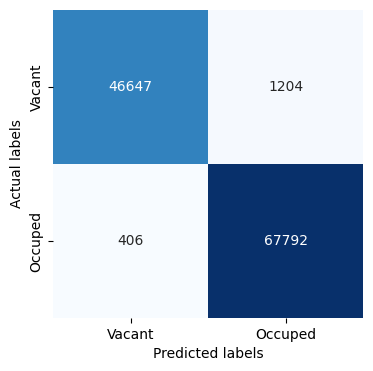

Training Loss in mean square error: 0.101492
Training Accuracy: 0.986127
Total Time require for Training 1.246899 Seconds


In [532]:
Lmax= 100
activation='s'
i_elm_model1=i_elmTraining(x_training_features,y_train_labels,activation)


precision= 0.9812485245017032 recall= 0.995449568906528 f1-score= 0.9882980349530394 auc-score= 0.015830901132848723
sensitivity= 0.40679348380125185 specificity= 0.9812485245017032 fpr= 0.01875147549829681
Confusion Matrix: [[19952   556]
 [  133 29095]]
                 Column1
Precision       0.981249
recall          0.995450
f1-score        0.988298
Accuracy Score  0.015831
sensitivity     0.406793
specificity     0.981249
fpr             0.018751


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


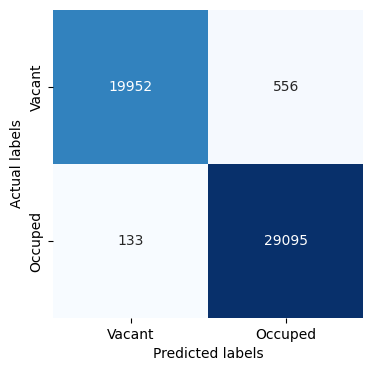

Testing Loss in mean square error: 0.105979  

Testing Accuracy: 0.986147
Total Time require for Testing one image is  1.977077534445348e-06 seconds


In [533]:
i_elmTesting(i_elm_model1,x_testing_features,y_testing_labels)

torch.Size([1, 2]) torch.Size([2048, 1]) torch.Size([116049, 2048])
precision= 0.9865893651909112 recall= 0.9881228188509927 f1-score= 0.9873554966227601 auc-score= 0.015509968393149009
sensitivity= 0.41054730894045816 specificity= 0.9865893651909112 fpr= 0.013410634809088773
Confusion Matrix: [[46935   916]
 [  810 67388]]
                 Column1
Precision       0.986589
recall          0.988123
f1-score        0.987355
Accuracy Score  0.015510
sensitivity     0.410547
specificity     0.986589
fpr             0.013411


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


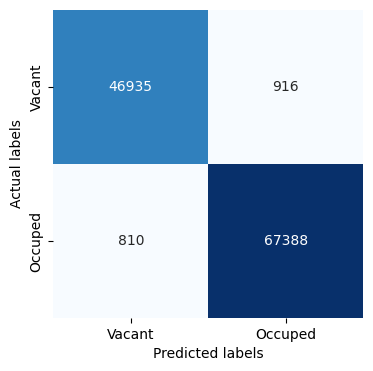

Training Loss in mean square error: 0.445694
Training Accuracy: 0.985127
Total Time require for Training 1.096234 Seconds


In [527]:
Lmax= 100
activation='t'
i_elm_model2=i_elmTraining(x_training_features,y_train_labels,activation)


precision= 0.990245738928058 recall= 0.9899069385520733 f1-score= 0.990076309756014 auc-score= 0.011995038623319677
sensitivity= 0.41140450809667184 specificity= 0.990245738928058 fpr= 0.009754261071941994
Confusion Matrix: [[20223   285]
 [  295 28933]]
                 Column1
Precision       0.990246
recall          0.989907
f1-score        0.990076
Accuracy Score  0.011995
sensitivity     0.411405
specificity     0.990246
fpr             0.009754


C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self(X), dtype=torch.float32)
C:\Users\Dr. Rajendra Ku Roul\AppData\Local\Temp\ipykernel_5080\1701976199.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_pred=torch.tensor(Y_pred,dtype=torch.float32)


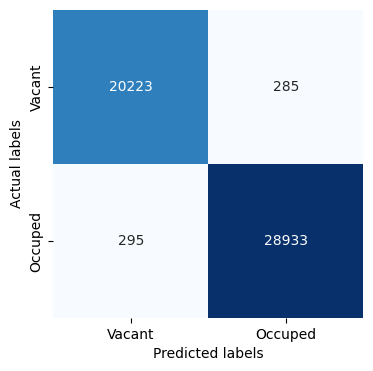

Testing Loss in mean square error: 0.445647  

Testing Accuracy: 0.988338
Total Time require for Testing one image is  2.892881761280616e-06 seconds


In [528]:
i_elmTesting(i_elm_model2,x_testing_features,y_testing_labels)

In [ ]:
y_train_labels_reshaped=np.argmax(y_train_labels.detach().cpu().numpy(),axis=1)


In [ ]:
y_test_labels_reshaped=np.argmax(y_testing_labels.detach().cpu().numpy(),axis=1)

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize and train the naive bayes classifier
naiveClassifier=GaussianNB(var_smoothing=1e-8)

start_time=time.time()
naiveClassifier.fit(x_training_features.cpu(),y_train_labels_reshaped)
end_time=time.time()

print("training_time =", end_time-start_time)

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
testing_start_time=time.time()
y_pred=naiveClassifier.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time=", testing_stop_time-testing_start_time)
# Evaluate the classifier
accuracy = accuracy_score(y_test_labels_reshaped,y_pred)
print("Accuracy:", accuracy)

precision_1 = precision_score(y_test_labels_reshaped, y_pred)
recall=recall_score(y_test_labels_reshaped, y_pred)
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)
cm = confusion_matrix(y_test_labels_reshaped, y_pred)

# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity)
print("sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)


SVM

In [ ]:
from sklearn.svm import SVC
import time
from sklearn.model_selection import GridSearchCV
svm=SVC(C=1,kernel='linear',gamma='auto')

start_time= time.time()
#svm=svm.cuda().to(device)
svm.fit(x_training_features.cpu(),y_train_labels_reshaped)
end_time=time.time()
print("training time=",end_time-start_time)


In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
testing_start_time=time.time()
y_pred=svm.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time=", testing_stop_time-testing_start_time)
# Evaluate the classifier
accuracy = accuracy_score(y_test_labels_reshaped,y_pred)
print("Accuracy:", accuracy)

precision_1 = precision_score(y_test_labels_reshaped, y_pred)
recall=recall_score(y_test_labels_reshaped, y_pred)
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)
cm = confusion_matrix(y_test_labels_reshaped, y_pred)

# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity,"sensivity=",sensitivity)

TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)

Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time
rf_classifier = RandomForestClassifier(n_estimators=100)
start_time= time.time()
rf_classifier.fit(x_training_features.cpu(),y_train_labels_reshaped)
end_time=time.time()
print("training time=",end_time-start_time)


In [ ]:
# Make predictions on the testing set
from sklearn.metrics import accuracy_score
testing_start_time=time.time()
y_pred = rf_classifier.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time=", testing_stop_time-testing_start_time)

# Evaluate the classifier
accuracy = accuracy_score(y_test_labels_reshaped, y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
precision_1 = precision_score(y_test_labels_reshaped, y_pred)
recall=recall_score(y_test_labels_reshaped, y_pred)
fscore=f1_score(y_test_labels_reshaped, y_pred)

cm = confusion_matrix(y_test_labels_reshaped, y_pred)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)

print("Specificity:", specificity)
print("sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)

dt

Decision tree classifier    

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier(criterion='gini')

start_time= time.time()
dt_classifier.fit(x_training_features.cpu(),y_train_labels_reshaped)
end_time=time.time()
print("training time=",end_time-start_time)


In [ ]:

# Make predictions on the testing set
from sklearn.metrics import accuracy_score
testing_start_time=time.time()
y_pred = dt_classifier.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time=", testing_stop_time-testing_start_time)

# Evaluate the classifier
accuracy = accuracy_score(y_test_labels_reshaped,y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
precision_1 = precision_score(y_test_labels_reshaped,y_pred)
recall=recall_score(y_test_labels_reshaped,y_pred)
fscore=f1_score(y_test_labels_reshaped,y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)

cm = confusion_matrix(y_test_labels_reshaped,y_pred)
#print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity)
print("sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create a Decision Tree classifier
dt_classifier1 = DecisionTreeClassifier(criterion='entropy')

start_time= time.time()
dt_classifier1.fit(x_training_features.cpu(),y_train_labels_reshaped)
end_time=time.time()
print("training time=",end_time-start_time)


In [ ]:

# Make predictions on the testing set
from sklearn.metrics import accuracy_score
testing_start_time=time.time()
y_pred = dt_classifier1.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time=", testing_stop_time-testing_start_time)

# Evaluate the classifier
accuracy = accuracy_score(y_test_labels_reshaped,y_pred)
print("Accuracy:", accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
precision_1 = precision_score(y_test_labels_reshaped,y_pred)
recall=recall_score(y_test_labels_reshaped,y_pred)
fscore=f1_score(y_test_labels_reshaped,y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)

cm = confusion_matrix(y_test_labels_reshaped,y_pred)
#print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity)
print("sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)


ET

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

# Create the Extra Trees classifier
clf = ExtraTreesClassifier(criterion="gini")

start_time=time.time()
clf.fit(x_training_features.cpu(), y_train_labels_reshaped)
#model.fit(, )
stop_time=time.time()
print("trainingtime=",stop_time-start_time)


In [ ]:

testing_start_time=time.time()
y_pred = clf.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time =", testing_stop_time-testing_start_time)

# Calculate accuracy score
accuracy = accuracy_score(y_test_labels_reshaped, y_pred)

print("accuracy:",accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)


# Assuming y_true and y_pred are your true and predicted labels, respectively
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_test_labels_reshaped, y_pred)
#print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity)
print("sensivity=",sensitivity)



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

# Create the Extra Trees classifier
clf1 = ExtraTreesClassifier(criterion="entropy")

start_time=time.time()
clf1.fit(x_training_features.cpu(), y_train_labels_reshaped)
#model.fit(, )
stop_time=time.time()
print("trainingtime=",stop_time-start_time)


In [ ]:

testing_start_time=time.time()
y_pred = clf.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time =", testing_stop_time-testing_start_time)

# Calculate accuracy score
accuracy = accuracy_score(y_test_labels_reshaped, y_pred)

print("accuracy:",accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)


# Assuming y_true and y_pred are your true and predicted labels, respectively
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_test_labels_reshaped, y_pred)
#print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity)
print("sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.001,  # Learning rate (step size shrinkage)
    objective='binary:logistic',  # Objective function for binary classification
    random_state=42,n_jobs=4,booster ="gbtree", gamma = 0
)
start_time=time.time()
model.fit(x_training_features.cpu(), y_train_labels_reshaped)
stop_time=time.time()
print("trainingtime=",stop_time-start_time)


In [ ]:

testing_start_time=time.time()
y_pred = model.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time =", testing_stop_time-testing_start_time)
report = classification_report(y_test_labels_reshaped, y_pred)
#print(report)
# Calculate accuracy score
accuracy = accuracy_score(y_test_labels_reshaped, y_pred)

print("accuracy:",accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
precision_1 = precision_score(y_test_labels_reshaped, y_pred)
recall=recall_score(y_test_labels_reshaped, y_pred)
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)


# Assuming y_true and y_pred are your true and predicted labels, respectively
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_test_labels_reshaped, y_pred)
print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity,"sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)


QDA

XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
model = xgb.XGBClassifier(
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.001,  # Learning rate (step size shrinkage)
    objective='binary:logistic',  # Objective function for binary classification
    random_state=42,n_jobs=4,booster ="gbtree", gamma = 0
)
start_time=time.time()
model.fit(x_training_features.cpu(), y_train_labels_reshaped)
stop_time=time.time()
print("trainingtime=",stop_time-start_time)


In [ ]:

testing_start_time=time.time()
y_pred = model.predict(x_testing_features.cpu())
testing_stop_time=time.time()
print("testing time =", testing_stop_time-testing_start_time)
report = classification_report(y_test_labels_reshaped, y_pred)
#print(report)
# Calculate accuracy score
accuracy = accuracy_score(y_test_labels_reshaped, y_pred)

print("accuracy:",accuracy)
from sklearn.metrics import precision_score,recall_score,f1_score
precision_1 = precision_score(y_test_labels_reshaped, y_pred)
recall=recall_score(y_test_labels_reshaped, y_pred)
fscore=f1_score(y_test_labels_reshaped, y_pred)
print("precision:",precision_1)
print("recall",recall)
print("f1-Score",fscore)


# Assuming y_true and y_pred are your true and predicted labels, respectively
# Assuming y_true and y_pred are your true and predicted labels, respectively
cm = confusion_matrix(y_test_labels_reshaped, y_pred)
print(cm)
# Extract true positives (TP), false positives (FP), false negatives (FN), and true negatives (TN) from the confusion matrix
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]
#print(tp,fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Specificity:", specificity,"sensivity=",sensitivity)
TPR= tp/(tp+fn)
FPR=fp/(fp+tn)
X=[0,TPR,1]
Y=[0,FPR,1]
AUCSCORE =np.trapz(Y,X)
print("AUCSCORE=", AUCSCORE)

